# 1.


In [1]:
### 이곳에서 과제를 진행해 주세요 ### 

TP = 4442
TN = 6165
FP = 1515
FN = 1930

# 정밀도
positives = TP + FP
precision = TP / positives

# 재현율
actual_positives = TP + FN
recall = TP / actual_positives

def my_f_beta_score(precision, recall, beta):
    return (1.0 + (beta **2)) * (precision * recall) / (((beta ** 2) * precision) + recall)

                                                        
beta = 2
print("f beta score : {}".format(my_f_beta_score(precision, recall, beta)))

f beta score : 0.7063126093178566


# 2.

In [2]:
### 이곳에서 과제를 진행해 주세요 ### 

# 기존 모델


import pandas as pd

# 데이터 불러오기
url_train = "https://raw.githubusercontent.com/tkryu91/drive/main/Code%20States/Section%202/n221/train.csv"
url_train_labels="https://raw.githubusercontent.com/tkryu91/drive/main/Code%20States/Section%202/n221/train_labels.csv"
url_test = "https://raw.githubusercontent.com/tkryu91/drive/main/Code%20States/Section%202/n221/test.csv"
url_submission = "https://raw.githubusercontent.com/tkryu91/drive/main/Code%20States/Section%202/n221/submission.csv"

target = 'vacc_h1n1_f'


train_raw = pd.merge(pd.read_csv(url_train),
                 pd.read_csv(url_train_labels)[target],
                left_index=True, right_index=True)


# train / val 데이터 나누기

from sklearn.model_selection import train_test_split

train, val = train_test_split(train_raw, train_size = 0.8, test_size = 0.2,
                             stratify = train_raw[target], random_state = 2)

# 엔지니어링

import numpy as np

def engineer(df):
    
#     duplicate = df[df.duplicated(keep='last')]
#     df.drop(duplicate.index, inplace=True)
    
    # behavior 관련 특성 묶어서 새로운 특성 만들기
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behavior'] = df[behaviorals].sum(axis=1)
    
    # opinion 관련 특성 ordinal data로 바꾸기
    df['opinion_h1n1_vacc_effective'].replace({'Not At All Effective' : 0,
                                             'Not Very Effective' : 1,
                                             'Dont Know' : 2,
                                             'Refused' : 3,
                                             'Somewhat Effective' : 4,
                                             'Very Effective' : 5},
                                            inplace=True)
    df['opinion_h1n1_risk'].replace({'Very Low' : 0,
                                   'Somewhat Low' : 1,
                                   'Dont Know' : 2,
                                   'Refused' : 3,
                                   'Somewhat High' : 4,
                                   'Very High' : 5},
                                  inplace = True)
    df['opinion_h1n1_sick_from_vacc'].replace({'Dont Know' : 0,
                                              'Refused' : 1,
                                              'Very Worried' : 2,
                                              'Somewhat Worried' : 3,
                                              'Not Very Worried' : 4,
                                              'Not At All Worried' : 5},
                                             inplace = True)
    
    df['opi'] = df[['opinion_h1n1_risk','opinion_h1n1_vacc_effective', 'opinion_h1n1_sick_from_vacc']].sum(axis=1)
  
    # 같은 뜻의 변수 묶어주기
    df['employment_status'].replace('Unemployed','Not in Labor Force', inplace=True)
    
    # 이상치 처리
    df['rent_own_r'].replace({77.0 : np.nan, 99.0 : np.nan})
    
    # h1n1 지식 관련 새로운 특성
    df['con_know'] = df[['h1n1_concern', 'h1n1_knowledge']].sum(axis=1)
    
    # seas 관련 항목 지우기
    dels = [col for col in df.columns if 'seas' in col]
    df.drop(columns=dels, inplace=True)
        
    return df

# 엔지니어링 적용
train = engineer(train)
val = engineer(val)


# X,y 값 설정

features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]


# 라이브러리 import
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)


from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from category_encoders import TargetEncoder
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from category_encoders import CatBoostEncoder
from sklearn.metrics import f1_score


# 인코더 별 칼럼 지정
target_col = ['employment_industry', 'state', 'employment_occupation']
cat_col = X_train.drop(columns = target_col).columns

# 파이프라인 생성
pipe7 = make_pipeline(
    TargetEncoder(cols = target_col),
    CatBoostEncoder(cols = cat_col),
    SimpleImputer(), 
    RandomForestClassifier(n_estimators = 512, n_jobs=-1, random_state=2, oob_score=True, class_weight='balanced',
                           criterion = "entropy", max_depth = 12, min_samples_leaf = 6)
)

# 모델 학습
pipe7.fit(X_train,y_train)
print('훈련 정확도: ', pipe7.score(X_train, y_train))
print('검증 정확도: ', pipe7.score(X_val, y_val))

y_pred_val = pipe7.predict(X_val)
print('검증 f1 score :',f1_score(y_val, y_pred_val))

<ipython-input-2-8f589c5813fe>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['behavior'] = df[behaviorals].sum(axis=1)
C:\Users\tkryu\anaconda3\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-2-8f589c5813fe>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

훈련 정확도:  0.8169202028289299
검증 정확도:  0.8127149804293679
검증 f1 score : 0.6352506352506353


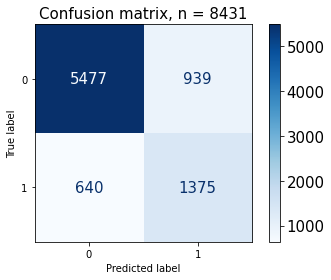

In [4]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.rc('font', size = 15)
pcm = plot_confusion_matrix(pipe7, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

False    6117
True     2314
dtype: int64

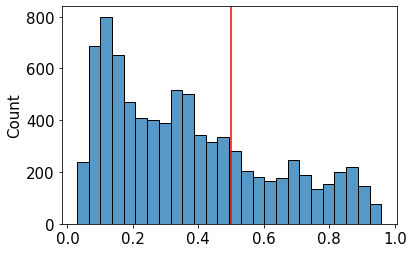

In [5]:
y_pred_proba = pipe7.predict_proba(X_val)[:, 1]

import seaborn as sns

threshold = 0.5
y_pred_proba = pipe7.predict_proba(X_val)[:, 1]
y_pred = y_pred_proba > threshold

ax = sns.histplot(y_pred_proba)
ax.axvline(threshold, color='red')

pd.Series(y_pred).value_counts()

In [6]:
from ipywidgets import interact, fixed

from sklearn.metrics import classification_report

def explore_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba >= threshold
    vc = pd.Series(y_pred).value_counts()
    ax = sns.histplot(y_pred_proba, kde=True)
    ax.axvline(threshold, color='red')
    ax.set_title(f'# of target, 1={vc[1]}, 0={vc[0]}')
    plt.show()
    print(classification_report(y_true, y_pred))

    
interact(explore_threshold, 
    y_true=fixed(y_val), 
    y_pred_proba=fixed(y_pred_proba), 
    threshold=(0, 1, 0.01));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

# 3.

estimator = 1


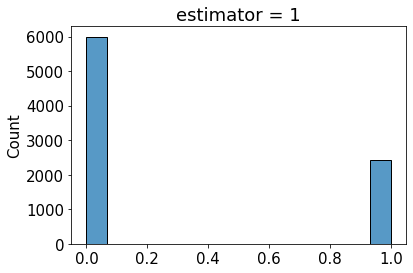

In [7]:
### 이곳에서 과제를 진행해 주세요 ###


def proba(n):

    pipe8 = make_pipeline(
        TargetEncoder(cols = target_col),
        CatBoostEncoder(cols = cat_col),
        SimpleImputer(), 
        RandomForestClassifier(n_jobs=-1, random_state=10, max_depth=None, n_estimators = n))
    
    pipe8.fit(X_train,y_train)
    
    y_pred_proba = pipe8.predict_proba(X_val)[:, 1]
    ax = sns.histplot(y_pred_proba)
    ax.set_title('estimator = {}'.format(n))
    return print("estimator = {}".format(n))

proba(1)

estimator = 10


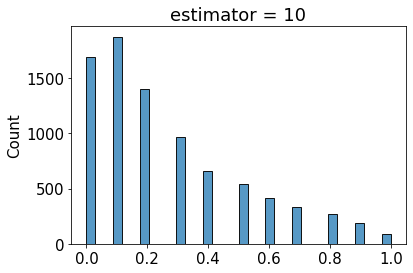

In [8]:
proba(10)

estimator = 100


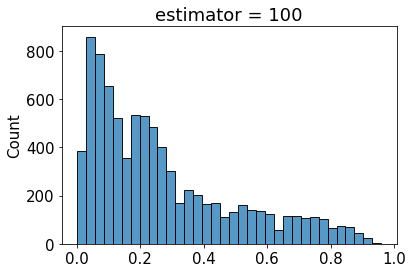

In [9]:
proba(100)

estimator = 1000


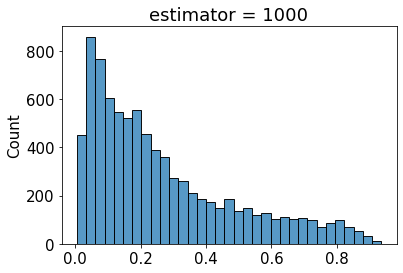

In [10]:
proba(1000)

# 4.

In [11]:
### 이곳에서 과제를 진행해 주세요 ### 

y_pred_proba = pipe7.predict_proba(X_val)[:, 1]


from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
roc.head()

,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000,0.000000,1.958983
1,0.000000,0.000496,0.958983
2,0.000000,0.002481,0.952579
3,0.000156,0.002481,0.952542
4,0.000156,0.019851,0.934847


In [12]:
# threshold 최대값의 인덱스, np.argmax()
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', threshold:', optimal_threshold)

idx: 1166 , threshold: 0.4493116743771476


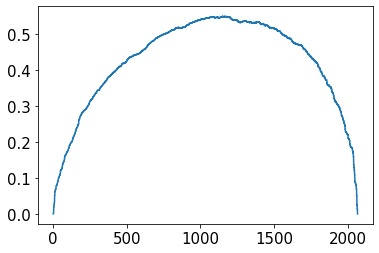

In [13]:
plt.plot(tpr-fpr);

In [31]:
y_pred_optimal = y_pred_proba >= 0.5
print(f1_score(y_val, y_pred_optimal))
print(classification_report(y_val, y_pred_optimal))

0.6352506352506353
              precision    recall  f1-score   support

           0       0.90      0.85      0.87      6416
           1       0.59      0.68      0.64      2015

    accuracy                           0.81      8431
   macro avg       0.74      0.77      0.75      8431
weighted avg       0.82      0.81      0.82      8431



In [15]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_val, y_pred_proba)
auc_score

0.8519615198975266

In [33]:
pipe8 = make_pipeline(
    TargetEncoder(cols = target_col),
    CatBoostEncoder(cols = cat_col),
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, max_depth=None, n_estimators = 100))

pipe8.fit(X_train,y_train)

y_pred_proba8 = pipe8.predict_proba(X_val)[:, 1]
fpr8, tpr8, thresholds8 = roc_curve(y_val, y_pred_proba8)
auc_score8 = roc_auc_score(y_val, y_pred_proba8)
auc_score8

0.8409520166704826

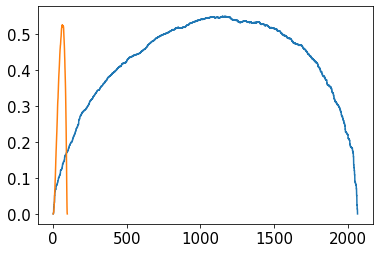

In [38]:
plt.plot(tpr-fpr);
plt.plot(tpr8-fpr8);

In [16]:
test_raw = pd.read_csv(url_test)
submission = pd.read_csv(url_submission)

test = engineer(test_raw)
trainer = engineer(train_raw)

X_trainer = trainer[features]
y_trainer = trainer[target]

pipe7.fit(X_trainer, y_trainer)

y_pred_trainer = pipe7.predict(X_trainer)
y_pred_trainer_proba = pipe7.predict_proba(X_trainer)[:, 1]
y_pred_trainer_optimal = y_pred_trainer_proba >= 0.5
print(f1_score(y_trainer, y_pred_trainer_optimal))

0.6470377019748653


In [ ]:
y_pred_test = pipe7.predict(test)
submission['vacc_h1n1_f'] = y_pred_test
# submission.to_csv("submission7.csv", index=False)

# 5.

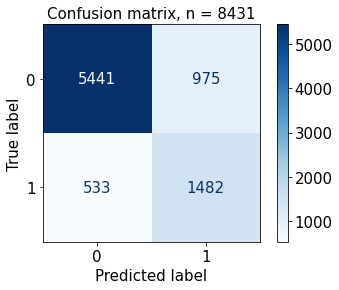

In [39]:
### 이곳에서 과제를 진행해 주세요 ### 

fig, ax = plt.subplots()
plt.rc('font', size = 15)
pcm = plot_confusion_matrix(pipe7, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

In [43]:
tp = 1482
fp = 975
tn = 5441
fn = 533

precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(precision, recall)

0.6031746031746031 0.7354838709677419


오늘의 세션을 통해 임계값의 중요성에 대해 배웠지만, 이미 내 모델은 디폴트 값인 0.5에 최적화가 되어 있는 듯 했다. 때문에 성능을 올리지는 못하였다. 

grid cv를 실행해보지는 않았지만, 엄청난 수작업으로 충분히 파라미터에 대한 최적값을 찾았다고 생각해, grid cv를 사용한다고 파라미터들의 새로운 최적값을 찾긴 힘들 것 같다. 
다만, 전처리 과정에 변화가 생기면 그때는 수작업 보다는 grid cv를 사용해보도록 하겠다. 

엔지니어링에 대한 고민과 시도를 상당히 많이 했음에도, 성능은 엔지니어링 결과에 따라 왔다 갔다 했다. 
(여러 항목에 똑같은 엔지니어링을 했음에도 어떤 항목은 오히려 점수를 내리기도 했다.)
때문에 어떻게 엔지니어링을 해야 성능을 올리는 지 더 공부해봐야 할 듯 하다. 